In [1]:
# Import all the neccesary libraries and modules that will be used throughout the project

In [2]:
import cv2
import tensorflow as tf
import pandas as pd
import itertools
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [3]:
# Here we build a function that preproccess our images with OpenCV

In [4]:
img_dir = "cell_images"  
img_size = 150

def load_img_data(path):
    image_files = glob.glob(os.path.join(path, "Parasitized/*.png")) + \
    glob.glob(os.path.join(path, "Uninfected/*.png"))
    x, y = [], []
    for image_file in image_files:
        if "Uninfected" in image_file:
            label = 0
        else:
            label = 1
        img_array = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img_array, (img_size, img_size))
        x.append(img_resized)
        y.append(label)
    return x, y

In [5]:
# Normalizing and preparing our data
# train_test_split() help us to split out data into train data and test data

In [6]:
x, y = load_img_data(img_dir)
x = np.array(x).reshape(-1, img_size, img_size, 1)
x = x / 255
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Total training samples:", x_train.shape)
print("Total validation samples:", x_test.shape)

Total training samples: (24786, 150, 150, 1)
Total validation samples: (2754, 150, 150, 1)


In [7]:
# Showing image from the prepared data

1


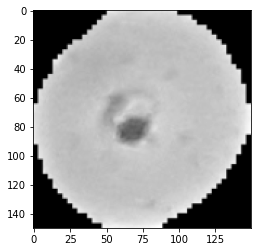

In [8]:
index = 20
plt.imshow(x_train[index], cmap="gray")
print(np.argmax(y_train[index]))

In [9]:
# Here we build our model with 3 convolution layers 1 flatten and 3 dense layer

In [10]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], dilation_rate=(2, 2)))
model.add(Dropout(0.2))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(2))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()
history = model.fit(x_train, np.array(y_train), batch_size=64, epochs=2, validation_split=0.1)
print(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 64)      640       
                                                                 
 dropout (Dropout)           (None, 146, 146, 64)      0         
                                                                 
 activation (Activation)     (None, 146, 146, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0         
                                                        

In [11]:
# Plotting graphs for the model

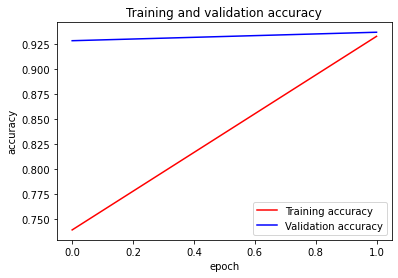

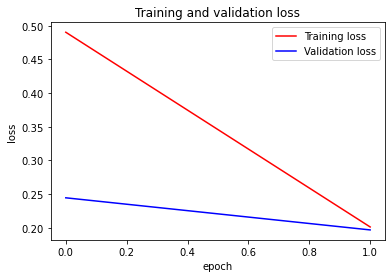

In [12]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [13]:
# model evaluation

In [14]:
loss, accuracy = model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Testing on {len(x_test)} images, the results are\n Accuracy: {accuracy} | Loss: {loss}")

Testing on 2754 images, the results are
 Accuracy: 0.9368191957473755 | Loss: 0.20257648825645447


In [15]:
pred = np.round(model.predict(x_test), 0)
print("Rounded test labels", pred)

Rounded test labels [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [16]:
# Implementing classification metrics

In [17]:
status = ["Uninfected", "Infected"]
classification_metrics = classification_report(y_test, pred, target_names=status, zero_division=False)
print(classification_metrics)

              precision    recall  f1-score   support

  Uninfected       0.90      0.98      0.94      1376
    Infected       0.97      0.90      0.94      1378

   micro avg       0.94      0.94      0.94      2754
   macro avg       0.94      0.94      0.94      2754
weighted avg       0.94      0.94      0.94      2754
 samples avg       0.94      0.94      0.94      2754



In [18]:
# Implementing confusion matrix

In [19]:
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_pred = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_pred)

Normalized confusion matrix


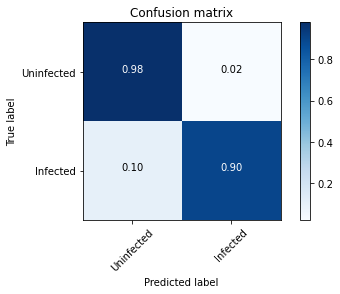

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
         print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
plot_confusion_matrix(cm, status, normalize=True)

In [21]:
# Testing the model with two images 1 Infected and 1 Uninfected

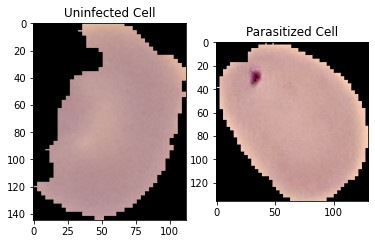

In [22]:
uninfected_cell = "Dataset1/Uninfected/C1_thinF_IMG_20150604_104722_cell_211.png"
infected_cell = "Dataset1/Parasite/3 (15).png"

_, ax = plt.subplots(1, 2)
ax[0].imshow(plt.imread(uninfected_cell))
ax[0].title.set_text("Uninfected Cell")
ax[1].imshow(plt.imread(infected_cell))
ax[1].title.set_text("Parasitized Cell")
plt.show()

In [23]:
img_array_uninfected = cv2.imread(uninfected_cell, cv2.IMREAD_GRAYSCALE)
img_array_infected = cv2.imread(infected_cell, cv2.IMREAD_GRAYSCALE)

img_array_uninfected = cv2.resize(img_array_uninfected, (img_size, img_size))
img_array_infected = cv2.resize(img_array_infected, (img_size, img_size))

img_array_infected = img_array_infected / 255
img_array_uninfected = img_array_uninfected / 255

img_array_infected = img_array_infected.reshape(1, *img_array_infected.shape)
img_array_infected = np.expand_dims(img_array_infected, axis=3)
img_array_uninfected = img_array_uninfected.reshape(1, *img_array_uninfected.shape)
img_array_uninfected = np.expand_dims(img_array_uninfected, axis=3)

In [24]:
# We are Using binary_crossentropy for our loss function in that case 0 for Unifected and 1 for infected
# so when the prediction accuracy is low then it has predic Uninfected but Infected when accuracy is high

In [26]:
status = ["Uninfected", "Infected"]
infected_result = model.predict(img_array_infected)
uninfected_result = model.predict(img_array_uninfected)
a = np.argmax(infected_result)
b = np.argmax(uninfected_result)
print(f"{status[a]}: {round(infected_result[0][a]*100)} %")
print(f"{status[b]}: {round(uninfected_result[0][b]*100)} %")

Infected: 91 %
Uninfected: 90 %


Uninfected


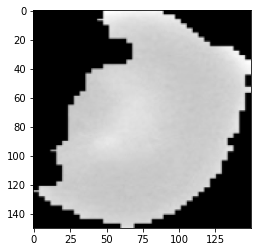

In [27]:
plt.imshow(img_array_uninfected.reshape(150, 150), cmap="gray")

prediction = model.predict(img_array_uninfected)
prediction = np.argmax(prediction)
if prediction == 1:
    prediction = 'Infected'
else:
    prediction = 'Uninfected'

print(prediction)

Infected


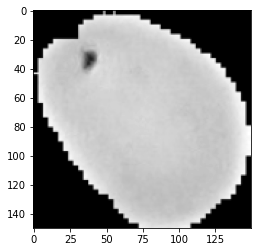

In [28]:
plt.imshow(img_array_infected.reshape(150, 150), cmap="gray")

prediction1 = model.predict(img_array_infected)
prediction1 = np.argmax(prediction1)
if prediction1 == 1:
    prediction1 = 'Infected'
else:
    prediction1 = 'Uninfected'

print(prediction1)

In [29]:
model.save("malariae_detection.h5") # Saving the model as 'malariae_detection.h5'

In [30]:
# Since the project is also predicting the specie for the Infected Plasmodium
# the condition is set to if the Image is Infected it can go ahead to the second phase to predict the specie

In [31]:
if (prediction == "Infected") or (prediction1 == "Infected"):
    # Data preparation (preproccessing)
    simg_dir = "SpeciesDataset/train"
    simg_size = 70
    
    def load_img_data(path):
        simage_files = glob.glob(os.path.join(path, "Falciparum/*.png")) + \
        glob.glob(os.path.join(path, "Malariae/*.png")) + \
        glob.glob(os.path.join(path, "Ovale/*.png")) + \
        glob.glob(os.path.join(path, "Vivax/*.png"))

        sx, sy = [], []
        for simage_file in simage_files:
            if "Falciparum" in simage_file:
                label = 0
            elif "Malariae" in simage_file:
                label = 1
            elif "Ovale" in simage_file:
                label = 2
            else:
                label = 3
            simg_array = cv2.imread(simage_file, cv2.IMREAD_GRAYSCALE)
            simg_resized = cv2.resize(simg_array, (simg_size, simg_size))
            sx.append(simg_resized)
            sy.append(label)
        return sx, sy

In [32]:
    sx, sy = load_img_data(simg_dir)
    sx = np.array(sx).reshape(-1, simg_size, simg_size, 1)
    sx = sx / 255
    sx_train, sx_test, sy_train, sy_test = train_test_split(sx, sy, test_size=0.1, stratify=sy)
    sy_train=to_categorical(sy_train)
    sy_test=to_categorical(sy_test)
    print("Total training samples:", sx_train.shape)
    print("Total validation samples:", sx_test.shape)

Total training samples: (1205, 70, 70, 1)
Total validation samples: (134, 70, 70, 1)


Falciparum


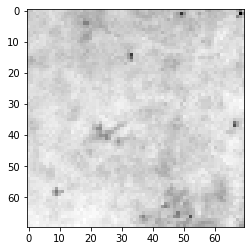

In [33]:
    species = ["Falciparum", "Malariae", "Ovale", "Vivax"]
    sindex = 20
    plt.imshow(sx_train[sindex], cmap="gray")
    MaxPosition0=np.argmax(sy_train[sindex])  
    prediction_label0=species[MaxPosition0]
    print(prediction_label0)

In [34]:
    # Model to predict specie

In [35]:
    speciesmodel = Sequential()
    speciesmodel.add(Conv2D(64, (3, 3), input_shape=sx_train.shape[1:], dilation_rate=(2, 2)))
    speciesmodel.add(Activation("relu"))
    speciesmodel.add(MaxPool2D(pool_size=(2, 2)))

    speciesmodel.add(Conv2D(64, (3, 3)))
    speciesmodel.add(Activation("relu"))
    speciesmodel.add(MaxPool2D(pool_size=(2, 2)))

    speciesmodel.add(Conv2D(64, (3, 3)))
    speciesmodel.add(Activation("relu"))
    speciesmodel.add(MaxPool2D(pool_size=(2, 2)))

    speciesmodel.add(Flatten())

    speciesmodel.add(Dense(64))
    speciesmodel.add(Activation("relu"))

    speciesmodel.add(Dense(64))
    speciesmodel.add(Activation("relu"))

    speciesmodel.add(Dense(4))
    speciesmodel.add(Activation("softmax"))

    speciesmodel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    speciesmodel.summary()
    shistory = speciesmodel.fit(sx_train, np.array(sy_train), batch_size=64, epochs=10, validation_split=0.1)
    print(shistory)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 66, 66, 64)        640       
                                                                 
 activation_6 (Activation)   (None, 66, 66, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 33, 33, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 64)        36928     
                                                                 
 activation_7 (Activation)   (None, 31, 31, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                  

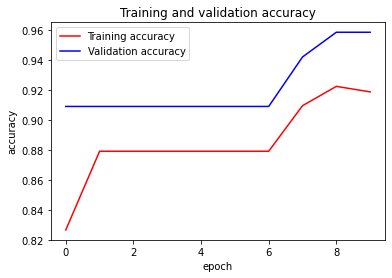

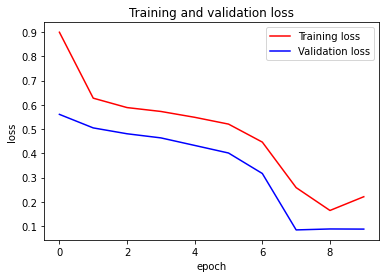

In [36]:
    saccuracy = shistory.history['accuracy']
    sval_accuracy = shistory.history['val_accuracy']
    sloss = shistory.history['loss']
    sval_loss = shistory.history['val_loss']
    sepochs = range(len(saccuracy))
    plt.plot(sepochs, saccuracy, 'r', label='Training accuracy')
    plt.plot(sepochs, sval_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(sepochs, sloss, 'r', label='Training loss')
    plt.plot(sepochs, sval_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [37]:
    sloss, saccuracy = speciesmodel.evaluate(sx_test, np.array(sy_test), verbose=0)
    print(f"Testing on {len(sx_test)} images, the results are\n Accuracy: {saccuracy} | Loss: {sloss}")

Testing on 134 images, the results are
 Accuracy: 0.9328358173370361 | Loss: 0.1296519637107849


In [38]:
    spred = np.round(speciesmodel.predict(sx_test), 0)
    print("Rounded test labels", spred)

Rounded test labels [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 

In [39]:
    sclassification_metrics = classification_report(sy_test, spred, target_names=species, zero_division=False)
    print(sclassification_metrics)

              precision    recall  f1-score   support

  Falciparum       1.00      1.00      1.00       118
    Malariae       0.00      0.00      0.00         6
       Ovale       0.00      0.00      0.00         3
       Vivax       0.00      0.00      0.00         7

   micro avg       1.00      0.88      0.94       134
   macro avg       0.25      0.25      0.25       134
weighted avg       0.88      0.88      0.88       134
 samples avg       0.88      0.88      0.88       134



In [40]:
    scategorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
    scategorical_pred = pd.DataFrame(pred).idxmax(axis=1)
    scm = confusion_matrix(scategorical_test_labels.values, scategorical_pred.values)

Normalized confusion matrix


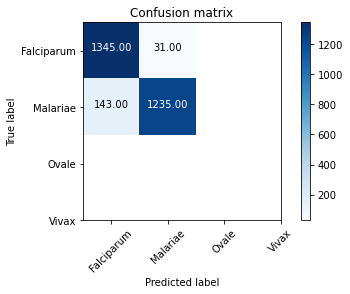

In [41]:
    def plot_confusion_matrix(cm, classes, normalize=False,
                              title="Confusion matrix",
                              cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype("float")
            print("Normalized confusion matrix")
        else:
             print("Confusion matrix, without normalization")

        plt.imshow(cm, interpolation="nearest", cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")

    plot_confusion_matrix(scm, species, normalize=True)

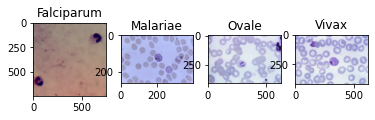

In [42]:
    falciparum = "SpeciesDataset/test/falciparum/plasmodium-phone-0001.png"
    malariae = "SpeciesDataset/test/Malariae/400px-12563_lores.png"
    ovale = "SpeciesDataset/test/ovale/Plasmodium_ovale_01.png"
    vivax = "SpeciesDataset/test/vivax/Plasmodium_vivax_01.png"

    _, ax = plt.subplots(1, 4)
    ax[0].imshow(plt.imread(falciparum))
    ax[0].title.set_text("Falciparum")
    ax[1].imshow(plt.imread(malariae))
    ax[1].title.set_text("Malariae")
    ax[2].imshow(plt.imread(ovale))
    ax[2].title.set_text("Ovale")
    ax[3].imshow(plt.imread(vivax))
    ax[3].title.set_text("Vivax")
    plt.show()

In [43]:
    img_array_ovale = cv2.imread(ovale, cv2.IMREAD_GRAYSCALE)
    img_array_vivax = cv2.imread(vivax, cv2.IMREAD_GRAYSCALE)
    img_array_malariae = cv2.imread(malariae, cv2.IMREAD_GRAYSCALE)
    img_array_falciparum = cv2.imread(falciparum, cv2.IMREAD_GRAYSCALE)

    img_array_ovale = cv2.resize(img_array_ovale, (simg_size, simg_size))
    img_array_vivax = cv2.resize(img_array_vivax, (simg_size, simg_size))
    img_array_malariae = cv2.resize(img_array_malariae, (simg_size, simg_size))
    img_array_falciparum = cv2.resize(img_array_falciparum, (simg_size, simg_size))
    
    img_array_ovale = img_array_ovale / 255
    img_array_vivax = img_array_vivax / 255
    img_array_malariae = img_array_malariae / 255
    img_array_falciparum = img_array_falciparum / 255

    img_array_ovale = img_array_ovale.reshape(1, *img_array_ovale.shape)
    img_array_ovale = np.expand_dims(img_array_ovale, axis=3)
    
    img_array_vivax = img_array_vivax.reshape(1, *img_array_vivax.shape)
    img_array_vivax = np.expand_dims(img_array_vivax, axis=3)
    
    img_array_malariae = img_array_malariae.reshape(1, *img_array_malariae.shape)
    img_array_malariae = np.expand_dims(img_array_malariae, axis=3)
    
    img_array_falciparum = img_array_falciparum.reshape(1, *img_array_falciparum.shape)
    img_array_falciparum = np.expand_dims(img_array_falciparum, axis=3)

In [44]:
    falciparum_result = speciesmodel.predict(img_array_falciparum)[0][0]
    malariae_result = speciesmodel.predict(img_array_malariae)[0][0]
    ovale_result = speciesmodel.predict(img_array_ovale)[0][0]
    vivax_result = speciesmodel.predict(img_array_vivax)[0][0] 
    
    print(f"Falciparum: {falciparum_result}")
    print(f"Malariae: {malariae_result}")
    print(f"Ovale: {ovale_result}")
    print(f"Vivax: {vivax_result}")

Falciparum: 0.9967367053031921
Malariae: 0.9352978467941284
Ovale: 0.08853518217802048
Vivax: 0.02058061771094799


Predicted 100 %
Falciparum


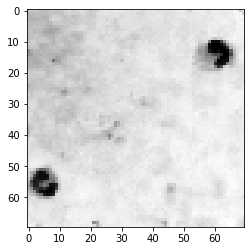

In [46]:
    plt.imshow(img_array_falciparum.reshape(70,70), cmap="gray")
    
    preds = speciesmodel.predict(img_array_falciparum)
    prd = np.argmax(preds)
    print("Predicted", round(preds[0][prd]*100),"%")
    
    prediction_label = species[prd]
    print(prediction_label)

Predicted 94 %
Falciparum


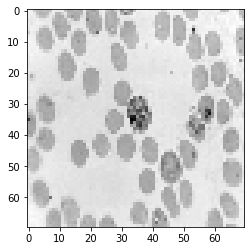

In [48]:
    plt.imshow(img_array_malariae.reshape(70,70), cmap="gray")

    preds1 = speciesmodel.predict(img_array_malariae)
    prd1 = np.argmax(preds1)
    print("Predicted", round(preds1[0][prd1]*100),"%")
      
    prediction_label1 = species[prd1]
    print(prediction_label)

Predicted 9 %
Malariae


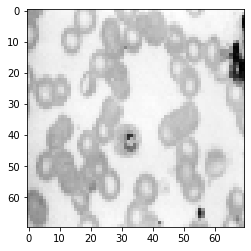

In [50]:
    plt.imshow(img_array_ovale.reshape(70,70), cmap="gray")
    
    preds2 = speciesmodel.predict(img_array_ovale)
    prd2 = np.argmax(preds2)
    print("Predicted", round(preds2[0][prd]*100),"%")
     
    prediction_label2 = species[prd2]
    print(prediction_label2)

Predicted 2 %
Malariae


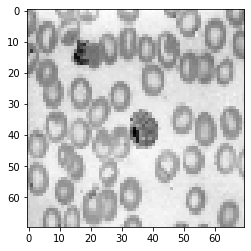

In [52]:
    plt.imshow(img_array_vivax.reshape(70,70), cmap="gray")
    
    preds3 = speciesmodel.predict(img_array_vivax)
    prd3 = np.argmax(preds3)
    print("Predicted", round(preds3[0][prd]*100),"%")
      
    prediction_label3=species[prd3]
    print(prediction_label3)

In [53]:
speciesmodel.save("species_model.h5") # Save model as 'species_model.h5'

In [ ]:
# For Dialated convolution, we can increase the kernel of the current model 
# Where kernel can be either 3, 5 or 7 as the case maybe but it should be a prime number